Build a regression model.

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [14]:
bike_poi_df = pd.read_csv('../data/joined_bikes.csv')
bike_poi_df = bike_poi_df.drop('Unnamed: 0',axis=1)
bike_poi_df = bike_poi_df[bike_poi_df['distance_meters'] < 201]
bike_poi_df.describe()

,distance_meters,popularity,rating,lat,long,bikes_available,bikes_in_use,total_bikes
count,45889.000000,15384.000000,5985.000000,45889.000000,45889.000000,45889.000000,45889.000000,45889.000000
mean,60.389331,0.696245,7.148204,52.510455,13.389849,1.847763,3.354006,5.156399
std,25.338322,0.306045,1.035183,0.025355,0.053063,2.352336,2.439783,3.252509
min,0.000000,0.000088,4.100000,52.438212,13.228195,0.000000,0.000000,2.000000
25%,41.000000,0.453704,6.400000,52.494314,13.346871,0.000000,2.000000,4.000000
50%,61.000000,0.854558,7.200000,52.510176,13.396425,1.000000,3.000000,4.000000
75%,80.000000,0.944794,7.900000,52.527044,13.428717,3.000000,4.000000,4.000000
max,200.000000,0.999940,9.500000,52.637125,13.607622,17.000000,22.000000,33.000000


<AxesSubplot:>

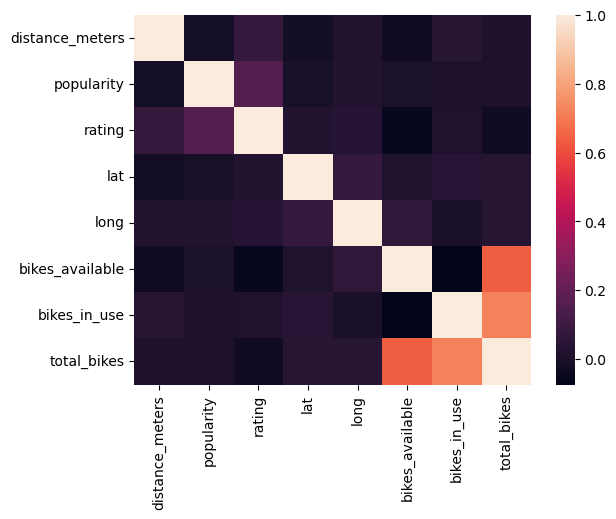

In [15]:
# I need to make a model that demonstrates a relationship between the number of bikes at a station and the charactaristics
# of the POIs there.
import seaborn as sns
sns.heatmap(bike_poi_df.corr())
# Looking at my sad heatmap again I think I'll have to 'unpack' the data in the 'category' column to be binary.
# For example I could add a columns called 'near_restaurant'/'near_cafe'/'residential'/etc where 0 is False and 1 is True.
# This would be tied to origin like total_bikes is. One issue that immediatley pops into mind with this is the 'poi density' of 
# different origins. Some have 50 POIs tied to them. Some have 5. I'll have to group by origin, total_bikes, and the categorical
# columns to void this. Essentially unjoining the two tables..

In [16]:
bike_poi_df['category'] = bike_poi_df['category'].str.lower()
# Just in case

In [17]:
bike_poi_df['category'].value_counts().head()

business and professional services    2985
clothing store                        1154
attorney / law office                 1066
hair salon                             952
café                                   865
Name: category, dtype: int64

In [18]:
#           declare new column               do a lambda transform so we can evaluate every category in each grouped origin
bike_poi_df['near_restaurant'] = bike_poi_df.groupby('origin')['category'].transform(
    lambda x: x.str.contains('restaurant').any()
    ).map({True: 1, False: 0})
#   set the value of the new column


# Run this to get a feel of the impact this new column will have. for example take technology business at 384 occurences.
bike_poi_df.groupby('origin')['category'].transform(
    lambda x: x.str.contains('business').any()
    ).value_counts()
# if we try this chunk of code with contains('business') it's way too vague and will change nearly 40k rows.
# if we try it with ('technology') it only changes 10k rows.
# we can also do to see exactly what categories it's picking up.
bike_poi_df[bike_poi_df['category'].str.contains('technology',na=False)].category.value_counts()
# In this case it's only referencing 'technology business' I think it's a good add.

bike_poi_df['near_tech'] = bike_poi_df.groupby('origin')['category'].transform(
    lambda x: x.str.contains('technology').any()
    ).map({True: 1, False: 0})
bike_poi_df.head(1)

# I am going to keep testing and adding these binary columns. I'll just print the final database in the cell below to avoid clutter.

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
bike_poi_df = pd.read_csv('../data/joined_bikes_expanded.csv') # If you reload the file run this.
bike_poi_df = bike_poi_df.drop('Unnamed: 0',axis=1)
bike_poi_df.head(1)
# I zoned out and we're at nearly 100 columns now...
# bike_poi_df.to_csv('../data/joined_bikes_expanded.csv') save before I lose my work.

,name,distance_meters,category,popularity,rating,lat,long,origin,bikes_available,bikes_in_use,...,near_language_school,near_music_school,near_nursery_school,near_driving_school,near_publisher,near_pub,near_bookstore,near_library,near_bridge,near_landmark
0,Curry Wolf,29.0,fast food restaurant,0.903641,7.8,52.503902,13.335662,"52.504157,13.335328",4,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(20,15))
sns.heatmap(bike_poi_df.corr())
# needles to say, this is too chaotic to digest. It does seem like there's more connections though so that's good.

# total bikes will be dependent.

In [4]:
# only grab columns relevant to station
stations = bike_poi_df[bike_poi_df.columns[7:].to_list()]

In [14]:
distinct_stations = stations.drop_duplicates()
distinct_stations = distinct_stations.drop(['bikes_in_use','bikes_available'],axis=1)
y = distinct_stations['total_bikes']
distinct_stations = distinct_stations.drop(['total_bikes','origin','near_landmark'],axis=1)
X_tmp = distinct_stations[distinct_stations.columns.to_list()]
col = X_tmp.columns
X = sm.add_constant(X_tmp)

In [ ]:
def elimination(X,y,col):

    while len(col)>0 :
        model=sm.OLS(y,X[col])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.0045):
            return result
            break
        else:
            col=col.drop(largest_pvalue.index)
            print('dropped',largest_pvalue)

result = elimination(X,y,col)

In [21]:
distinct_stations = stations.drop_duplicates()
distinct_stations = distinct_stations.drop(['bikes_in_use','bikes_available'],axis=1)
y = distinct_stations['total_bikes']
distinct_stations = distinct_stations.drop(['total_bikes','origin','near_landmark'],axis=1)
indep = distinct_stations[distinct_stations.columns.to_list()]
X = [sm.add_constant(indep[column]) for column in indep.columns] 

In [33]:
# As a challenge I took Jeremy's forward selection code from his lecture and automated it.

# y is still the dependent var.
# X this time is a list containing each column in x that has been turned into a df with a constant.
def addition(X,y):
    df_list = list()
    best_r = -1
    r_val = 0
    remaining_var = distinct_stations.copy()
    # Set r_v to d_s so it will be easier to automate 
    while(best_r < r_val):
        Models = [sm.OLS(y,x) for x in X] #list of models
        Results = [model.fit() for model in Models] #list of results
        Adj_Rsquared = [results.rsquared_adj for results in Results] #list of rsquared

        # Find highest r value and the column it came from
        tmp_dict = dict()
        for i in range(len(Adj_Rsquared)):
            tmp_dict[remaining_var.columns[i]] = Adj_Rsquared[i]

        tmp_df = pd.DataFrame.from_dict(tmp_dict.items())
        r_col = tmp_df.max().values[0]
        r_val = tmp_df.max().values[1]
        print(r_val)
        print(r_col)

        # This is a list of the already selected columns.
        df_list.append(r_col)

        # drop the selected column from the pool 
        remaining_var = remaining_var.drop(r_col,axis=1)
        included_df =  distinct_stations[df_list]
        X = [sm.add_constant(pd.merge(included_df,remaining_var[column], right_index = True, left_index = True)) for column in remaining_var.columns]
        best_r = r_val
        
        
    return df_list
        

result2 = addition(X,y)
result2

0.008314398003676504
near_website_designer
0.007936850237894033
near_warehouse
0.008123286593012757
near_travel
0.007661911610806538
near_transportation
0.00788213559486095
near_translator
0.007320261777142512
near_telecom
0.0067819069251410236
near_tech
0.007476404064799991
near_tea_and_coffee
0.007065922807311553
near_sushi
0.006619896066658804
near_studio
0.006069099552451607
near_skin_care
0.005533003802497216
near_shoe_store
0.005864340852621219
near_shipping
0.005838728694224304
near_retail
0.006508038823712092
near_restaurant
0.008585309808883723
near_recreation
0.00849949454396115
near_real_estate
0.009486711300114026
near_publisher
0.010451577790353106
near_pub
0.010205531946843704
near_prof_service
0.010320879846802189
near_prof_cleaner
0.009807350492715305
near_print_store
0.009340104067162569
near_preschool
0.008796472253926324
near_plaza
0.013669902291754354
near_playground
0.01345241683293763
near_pizzeria
0.013486383821710635
near_park
0.013185255705991161
near_organizat

IndexError: index 0 is out of bounds for axis 0 with size 0

In [11]:
print()

NameError: name 'remaining_var_copy' is not defined

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            total_bikes   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.600
Method:                 Least Squares   F-statistic:                              222.4
Date:                Sun, 29 Jan 2023   Prob (F-statistic):                        0.00
Time:                        01:54:45   Log-Likelihood:                         -4823.4
No. Observations:                1771   AIC:                                      9671.
Df Residuals:                    1759   BIC:                                      9736.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
near_restaurant          1.5946      0.187      8.528      0.000       1.228       1.961
near_prof_service        2.4438      0.165     14.780      0.000       2.119       2.768
near_bakery              0.8151      0.201      4.059      0.000       0.421       1.209
near_bar                 0.7035      0.196      3.589      0.000       0.319       1.088
near_organization        1.3876      0.222      6.246      0.000       0.952       1.823
near_park                1.1595      0.378      3.070      0.002       0.419       1.900
near_museum              1.1550      0.370      3.118      0.002       0.429       1.881
near_prof_cleaner        0.9313      0.259      3.596      0.000       0.423       1.439
near_computer_repair     0.8232      0.277      2.971      0.003       0.280       1.366
near_playground          1.0397      0.308      3.380      0.001       0.436       1.643
near_plaza               1.2112      0.282      4.296      0.000       0.658       1.764
near_bridge              1.8387      0.398      4.619      0.000       1.058       2.619
==============================================================================
Omnibus:                      714.302   Durbin-Watson:                   1.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3739.905
Skew:                           1.842   Prob(JB):                         0.00
Kurtosis:                       9.092   Cond. No.                         5.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Provide model output and an interpretation of the results. 

# Stretch

How can you turn the regression model into a classification model?